
# Quantized model

This a simple example to reveal some basic working principle of quantization and its implementation in oneDNN & OpenVINO.

Linear quantization of input/output tensor data is defined by following dequantization equation:

$$
 x \approx Dequant_{s,z}(q) = s \cdot (q - z)
$$

This representation has 2 parameters (per tensor or per channel in practice):
 - s determines to what scale to enlarge the range of quantized value q, and it's a float point value
 - z determines the quantized value to be mapped as 0, and it's an integer

Strictly speaking, the so-called floating point value defined by IEEE 754 is also quantized representation since 32-bits or 64-bits still has limited number of discrete values, but that representation is hybrid between exponential and linear rather than pure linear which covers larger (still limited) range with precision lower and lower at larger and larger scale:
$$
  x \approx 1.Fractional \cdot 2^{Exponent-127}
$$

And the fixed-point values used in signal processing can be viewed as a special case of linear quantization described here (it uses 0 as z and $2^{-N}$ as s).

In STATIC quantization, s and z are choosed by offline statistics collected on calibration data set, at runtime they are constant.

### Inference with quantized representation
The same kind of arithmetics generally run faster or requires less resource on interger types, so convert input into such representation can boost performance. but depending on the calculation to be done, we need additional modification to make the result correct. 

for example multiply-accumulation based fully-connected(matmul) or convolution layer can be done as following:

$$
   r = \sum_{ij} x_i y_j \approx \sum_{ij} Dequant_{s_x,z_x}(x^q_i) \cdot Dequant_{s_y,z_y}(y^q_j) \\
                  = s_x s_y \sum_{ij} (x^q_i - z_x)(y^q_i - z_y) \\
                  = s_x s_y \sum_{ij} (x^q_i y^q_i -  x^q_i z_y - y^q_i z_x + z_x z_y) \\
                  = s_x s_y (\sum_{ij} x^q_i y^q_i -  z_y \sum_{ij} x^q_i -  z_x \sum_{ij} y^q_i + z_x z_y \sum_{ij}1) \\
                  = s_x s_y Q
$$

In this calculation
 - to use integer arithmetic, we needs more than just quantized input, the scales and zero-points of each input are also required.
 - U8/I8 integer multiplication results U16/I16 integer result, and sum them together requires type U32/I32, Q is interger
 - usually one of x and y is constant weight, this means only computation of item with $x^q$ needs to be done at runtime.
 - if weight choose to use 0 as it's zeropoint, then only $\sum_{ij} x^q_i y^q_i$ needs to be done at runtime, that's why weight is usually I8 with 0 as zero point.
 - the term $s_x s_y$ is a constant real number, the multiplication with integer Q has to be done in float-point, but this is often postponed and combined with future `re-quantize` step.

Not many computation can benefit quantized represenation, for example, transcendental functions, since you cannot recover f(s(q-z)) from f(q) easily, for these operations, we have to keep using float point.

### Symmetric vs Asymmetric
if we choose 0 as the zero point, then it's called "Symmetric" quantization mode, otherwise it's "Asymmetric", this is controlled by OpenVINO POT's `preset` configuration:
 - `performance`: using symmetric quantization for both weight and activations , this produces best performance since only $\sum_{ij} x^q_i y^q_i$ needs to be calculated at runtime.
 - `mixed`: using symmetric quantization for weight and asymmetric quantization for activations, this produces less quantization error but more computations.

https://docs.openvino.ai/latest/pot_compression_algorithms_quantization_README.html

### Combine De-quantize with Re-quantize
Usually we don't recover Q to float by multiply it with $s_x s_y$, because we have to quantize it immediately for feeding into next layer, this `re-quantization` step is done as following (an approximation again since these are two different representations)

$$
    s_r(r^q - z_r) \approx s_x s_y Q \\
    r^q \approx round(\frac{s_x s_y}{s_r} Q) + z_r
$$

In practice, OPs like `convolution` and `matmul` will not handle these complex `scales` and `zero point` kind of stuff, instead they do the exact same arithmetics as float-point cases, only difference is that they doing it with integer data types and integer arithmetics. all other corrections related to quantization are considered as some post-process steps that may or may be fused with the core operations. This keeps the concept clear.

### oneDNN example
in `static_q10n_matmul()` from [this oneDNN example](https://docs.oneapi.io/versions/latest/onednn/cpu_matmul_quantization_cpp.html
) we can see, it requires additional `set_zero_points()/set_output_scales()` to be called on `matmul_attr`, and it only needs minimal neccessary (it doesn't need each individual input scales):

 - zero points: $z_x$ and $z_y$
 - output scales: $\frac{s_x s_y}{s_r}$

these steps are performed as if a post-processing steps, if you don't set them, matmul still works to only calculate the $\sum_{ij} x^q_i y^q_i$ part.

## Install POT

first we need install [POT tool](https://docs.openvino.ai/latest/pot_README.html):

I found following commands work well to install POT from source tree in editiable mode:

```bash
$ python3 -m pip install --user -e ~/openvino/thirdparty/open_model_zoo/tools/accuracy_checker/
$ python3 -m pip install --user -e ~/openvino/tools/mo/
$ python3 -m pip install --user -e ~/openvino/tools/pot
```

## A simple network example

We build a very small network to test POT

cnntest is serialized to IR: ./cnntest.xml ./cnntest.bin


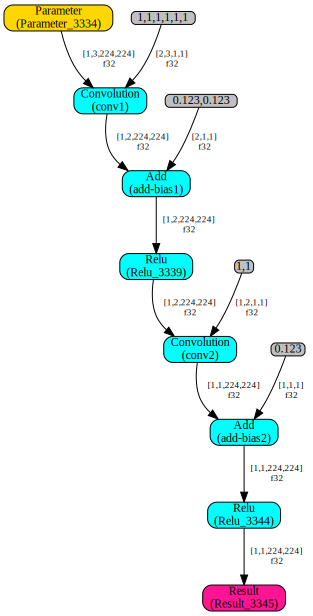

In [11]:
from openvino.preprocess import PrePostProcessor
import openvino.runtime as ov
import numpy as np
import ovhelper

core = ov.Core()

def org_model():
    input_shape = [1, 3, 224, 224]
    param_node = ov.op.Parameter(ov.Type.f32, ov.Shape(input_shape))

    def conv_layer(input, id, c_in, c_out):
        padding_begin = padding_end = [0, 0]
        weight = ov.op.Constant(ov.Type.f32, ov.Shape([c_out,c_in,1,1]), np.ones([c_in*c_out]))
        weight.set_friendly_name("weight{}".format(id))
        conv = ov.opset8.convolution(input, weight, [1, 1], padding_begin, padding_end, [1, 1], name="conv{}".format(id))
        conv.set_friendly_name("conv{}".format(id))
        bias = ov.op.Constant(ov.Type.f32, ov.Shape([c_out,1,1]), np.ones([c_out])*0.123)
        bias.set_friendly_name("bias{}".format(id))
        add = ov.opset8.add(conv, bias)
        add.set_friendly_name("add-bias{}".format(id))
        return ov.opset8.relu(add)
    
    n1 = conv_layer(param_node, 1, 3, 2)
    n2 = conv_layer(n1, 2, 2, 1)

    #maxpool_node = ov.opset1.max_pool(conv_node, [4, 4], padding_begin, padding_end, [4, 4], 'ceil')
    #relu_node = ov.opset8.relu(maxpool_node)
    #reshape_node = ov.opset8.reshape(relu_node, [-1], False)
    model = ov.Model(n2, [param_node], 'cnntest')
    return model

model = org_model()
model_path, weight_path = model.serialize("./{}.xml".format(model.get_friendly_name()))
print("{} is serialized to IR: {} {}".format(model.get_friendly_name(), model_path, weight_path))

model.visualize()

## What did POT do to the model?

Now let's trigger POT and see the result model:

In [12]:
# Uncomment following line to run POT tools in CLI
#!rm -rf pot_result/
#!~/.local/bin/pot -q default --preset performance --name cnntest -m ./cnntest.xml -w ./cnntest.bin --engine simplified --output-dir pot_result --data-source ./pot_dataset


./pot_result_mixed/model_name_DefaultQuantization/2022-03-03_03-28-27/optimized/cnntest.xml


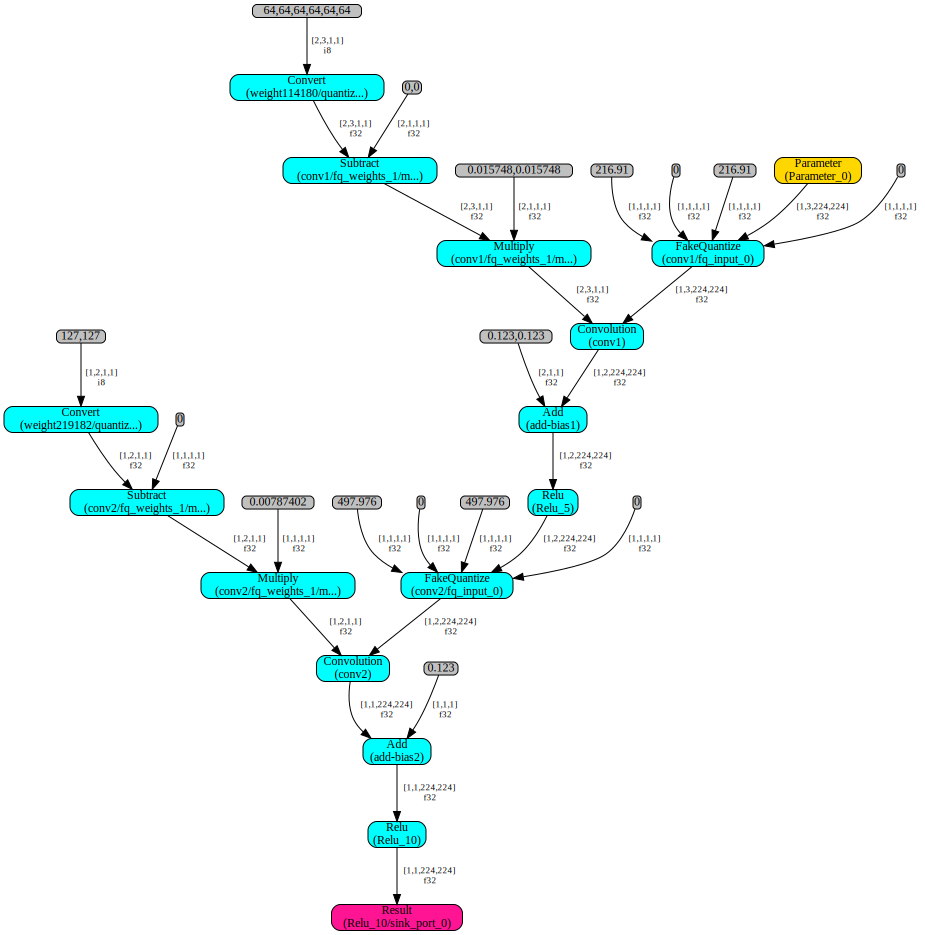

In [13]:
import os
for root, dirs, files in os.walk("./pot_result"):
    if 'cnntest.xml' in files:
        break

pot_model_path = os.path.join(root,"cnntest.xml")

print(pot_model_path)

model_quant = core.read_model(pot_model_path) 
# ovhelper.print_model(model_quant)
ovhelper.visualize_model(model_quant)

POT embedded quantization parameters inside the output model by inserting `FakeQuantize` layer at key path:

for `conv1`
 - weight is compressed to INT8 in storage and a dequantization subgraph `convert-substract-multiply` is applied to it to recover orginal floatting point values before feeding to convolution, and zero point is choosen to be 0 (to save computations)
 - input is also `FakeQuantize`-ed, with same input and output range and type, but output levels are limited to 256
 - so at runtime `conv1` can exploit the quantized representation of inputs to use integer arithmetics.

for `add-bias1` & `relu`
 - the const to add is not quantized by POT, that means this needs to be done in float precision, and also this means `conv1` should output w/o quantization (output precision FP32)

for `conv2`
 - inputs are `FakeQuantize`-ed again and weights are `Dequantized` from I8, thus it can use integer arithmetics too.

for `add-bias2` & `relu`
 - should be done in FP32

## What did CPU plugin do to the model?

The call graph start from compile_model is as follows, (steps doing graph transformations highlighted):

- compile_model()
  - IInferencePlugin::LoadNetwork()
    - IInferencePlugin::LoadExeNetworkImpl() overrided by
      - Engine::LoadExeNetworkImpl()
        - ...
        - `TransformationUpToCPUSpecificOpSet()`: common transformations, LPT included
        - `ConvertToCPUSpecificOpset()`
        - ...
        - MKLDNNExecNetwork's constructor
          - MKLDNNExecNetwork::GetGraph()
            - MKLDNNGraph::CreateGraph()
              - `MKLDNNGraph::Replicate()`: turns into CPU internal graph
              - `MKLDNNGraph::InitGraph()`
                - `MKLDNNGraphOptimizer::ApplyCommonGraphOptimizations`: 
                   CPU internal transformations not doable in ngraph, mainly fusion
                - `MKLDNNGraphOptimizer::ApplyImplSpecificGraphOptimizations`:

Now let's check the runtime model, here we added a enviroment variable `OPT_LINENUM` to stop CPU plugin's internal graph optimizations earlier at specific line number, so we can see what each step does more clearly.

Let's first check the output before CPU internal graph:

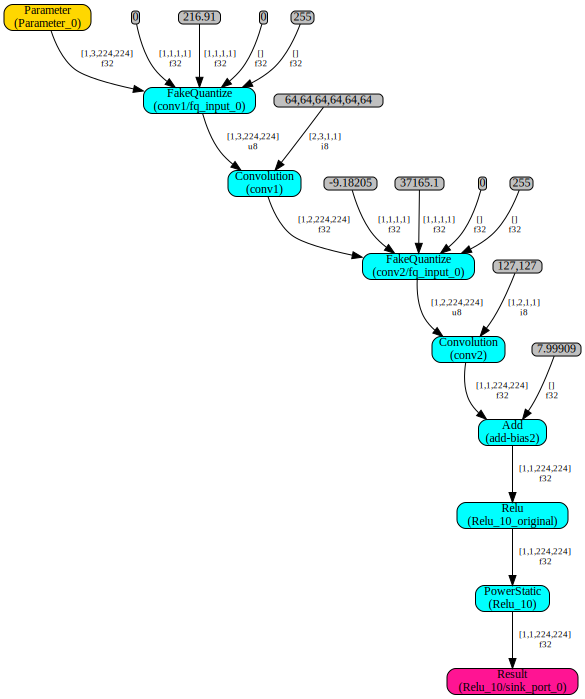

In [14]:
import os
def visualize_model_before_opt(OPT_LINENUM = 999999):
    os.environ["OPT_LINENUM"] = str(OPT_LINENUM)
    compiled_model_quant = core.compile_model(model_quant, "CPU")
    return ovhelper.visualize_model(compiled_model_quant.get_runtime_model())

visualize_model_before_opt(0)

### conv1/fq_input_0
FakeQuantize node `conv1/fq_input_0` is kept, but it's output range becomes 0-255, and output type becomes `U8`.

Thus the output of this step is considered to be quantized with following dequantization formula:
$$
  x \approx \frac{216.91}{255} (q - 0)
$$

so the (scale, zero_point) parameters are $(\frac{216.91}{255}, 0)$

### weight to conv1

It's kept as U8 but the dequantization subgraph `convert-substract-multipy` is removed, so it's now feeding quantized values directly into `conv1`.

the (scale, zero_point) parameters are $(0.015748, 0)$ according to orginal subgraph generated by POT.

### conv1

As both inputs are quantized with 0 as their zero-point value, the convolution can be done w/o any additional correction step, so we can see that no additional attributes are added to `conv1`, it only needs to performance normal convolution, and produce result in FP32 format.

But the LPT knows the output value (although in FP32 format) is actually only the $Q$ part we described earlier, and it needs to multiply $(0.015748 \cdot \frac{216.91}{255})$ to recover orginal output of `conv1`.

This scale-back operation can be think of as a part of the result `Re-quantization` work, and it's fused into next FakeQuantize node `conv2/fq_input_0`, which will be examined soon.

### `add-bias1` and `relu` is gone, Why?

They are fused into second FakeQuantize, thanks to the intelligent optimization done in common LPT(low precision transformations) code: [FakeQuantizeTransformation::fuseElementwise()](https://github.com/openvinotoolkit/openvino/blob/9cd3bff7df95ef5f00e64edd57307894d1213242/src/common/low_precision_transformations/src/fake_quantize.cpp#L121).

The basic principle is that, given [FakeQuantize's definition](https://docs.openvino.ai/latest/openvino_docs_ops_quantization_FakeQuantize_1.html):

```python
    if x <= min(input_low, input_high):
        output = output_low
    elif x > max(input_low, input_high):
        output = output_high
    else:
        # input_low < x <= input_high
        output = round((x - input_low) / (input_high - input_low) * (levels-1)) / (levels-1) * (output_high - output_low) + output_low
```

we have

```cpp
    b = relu(a + bias1);
    c = FakeQuantize(b, b_low, b_high, c_low, c_high);
    // according to POT output model:
    //   (b_low, b_high) == (c_low, c_high) == (0, 497.976)
```
Is equivalent to
```cpp
    c = FakeQuantize(a, b_low - bias1, b_high - bias1, c_low, c_high);
```

### conv2/fq_input_0

This step has it's input low/high parameter changed from POT's output model due to the `re-quantization` required, you can also think of this as pushing the dequantizations of weight & inputs though the `conv1` node and combine them with second FakeQuantize node.

Combined with the fused add-bias1 step, we can explain why the input range is changed from (0,497.976) to (-9.18, 37165.18):

```python
>>> import numpy as np
>>> r0 = np.array([0,497.976])
>>> bias1 = 0.123
>>> a = (0.015748*216.91/255)   # this is product of scales of weights & input for conv1
>>> list((r0 - bias1)/a)
[-9.182063912972968, 37165.18752248237]
```

The output type is U8 with range [0,255], with following quantization parameters:
$$
  x \approx \frac{497.976}{255} \cdot (q - 0)
$$

### conv2

Both inputs & weights for `conv2` are quantized with following parameters:
 -  weight's (scales, zero_point) = (0.00787402, 0) according to POT model
 -  input's (scales, zero_point) = $(\frac{497.976}{255}, 0)$

just like `conv1`, `conv2` also computes $Q$ only, to recover intended output scale, we need to multiple it further by $(\frac{497.976}{255}, 0) \cdot 0.00787402$ which is `0.015376756798117648`, and as usual, this operation is also delayed in case it may be merged with any future FakeQuantize along the path.

### add-bias2

This step is done on quantized tensor, thus orginal bias 0.123 is scaled to same level before being added with the tensor, the scaled result is 7.99909:
```python
>>> 0.123/(0.00787402*497.976/255) # this is product of scales of weights & input for conv2
7.999085998099228
```

### PowerStatic

This is newly introduce by LPT to actually recover quantized output to orginal range, with it's scale parameter set to `0.0153767578` which is pretty consistent with what predicted.

## Inspect the final runtime model

The final model didn't introduce drastic change to the basic computation flow, only did some minor modifications on implementation:

 - has proper memory layout (blocked) choosen
 - with more fusions
    - `conv1` fused with FakeQuantize node `conv2/fq_input_0` to output U8 directly, since it's basically a memory-bound element-wise operation that can benefits from fusion. we can be sure `conv2/fq_input_0` is done in FP32 and result is converted to U8.
    - `conv2` is fused with `add-bias2`/`relu` and internally it's done in FP32 too.

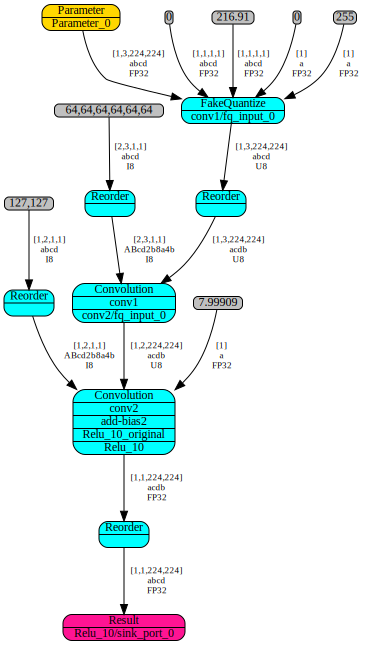

In [15]:
visualize_model_before_opt()

## Mixed mode

To actually use "Asymmetric" quantization, setting `preset` to `mixed` is not enough, since `relu` layer produces unsigned result which is naturally quantized by "Symmetric" unsigned quantization.

In [25]:

def org_model2():
    input_shape = [1, 3, 224, 224]
    param_node = ov.op.Parameter(ov.Type.f32, ov.Shape(input_shape))

    def conv_layer(input, id, c_in, c_out):
        padding_begin = padding_end = [0, 0]
        weight = ov.op.Constant(ov.Type.f32, ov.Shape([c_out,c_in,1,1]), np.ones([c_in*c_out]))
        weight.set_friendly_name("weight{}".format(id))
        conv = ov.opset8.convolution(input, weight, [1, 1], padding_begin, padding_end, [1, 1], name="conv{}".format(id))
        conv.set_friendly_name("conv{}".format(id))
        bias = ov.op.Constant(ov.Type.f32, ov.Shape([c_out,1,1]), np.ones([c_out])*(-255))
        bias.set_friendly_name("bias{}".format(id))
        add = ov.opset8.add(conv, bias)
        add.set_friendly_name("add-bias{}".format(id))
        return ov.opset8.tanh(add)
    
    n1 = conv_layer(param_node, 1, 3, 2)
    n2 = conv_layer(n1, 2, 2, 1)
    model = ov.Model(n2, [param_node], 'cnntest2')
    return model

model2 = org_model2()
model2.serialize("./{}.xml".format(model2.get_friendly_name()))

('./cnntest2.xml', './cnntest2.bin')

In [29]:
# Uncomment following line to run POT tools in CLI
!rm -rf pot_result_mixed/
!~/.local/bin/pot -q default --preset performance --name cnntest2 -m ./cnntest2.xml -w ./cnntest2.bin --engine simplified --output-dir pot_result_mixed --data-source ./pot_dataset


/home/hddl/.local/lib/python3.6/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: custom-tq-CVS-74980-3de17de5e388f43df774d3ba55fc50fc9ef91a94 is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,
INFO:openvino.tools.pot.app.run:Output log dir: pot_result_mixed/model_name_DefaultQuantization/2022-03-03_03-56-50
INFO:openvino.tools.pot.app.run:Creating pipeline:
 Algorithm: DefaultQuantization
 Parameters:
	preset                     : performance
	stat_subset_size           : 300
	target_device              : ANY
	model_type                 : None
	dump_intermediate_model    : False
	inplace_statistics         : True
	exec_log_dir               : pot_result_mixed/model_name_DefaultQuantization/2022-03-03_03-56-50
INFO:openvino.tools.pot.data_loaders.image_loader:Layout value is set [N,C,H,W]
INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                custom_tq/CVS-74980_3de17de5e388f43df77

./pot_result_mixed/model_name_DefaultQuantization/2022-03-03_03-56-50/optimized/cnntest2.xml


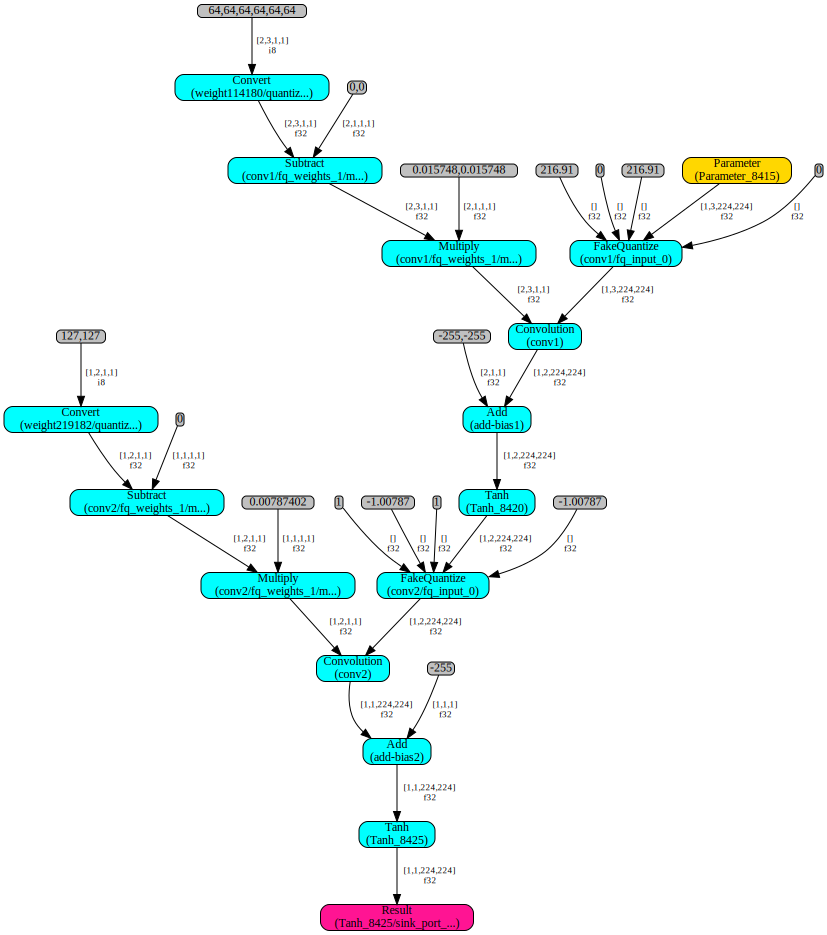

In [30]:
import os
for root, dirs, files in os.walk("./pot_result_mixed"):
    if 'cnntest2.xml' in files:
        break

pot_model_path = os.path.join(root,"cnntest2.xml")

print(pot_model_path)

model_quant = core.read_model(pot_model_path) 
# ovhelper.print_model(model_quant)
ovhelper.visualize_model(model_quant)

POT still only does 2 things:
 - symmetric quantize weight as I8 (even when all weights are positive)
 - insert FakeQuantize node before each convolution as quantize + dequantize

Actually from the generated model we didn't see any difference between `performance` and `mixed` preset. 


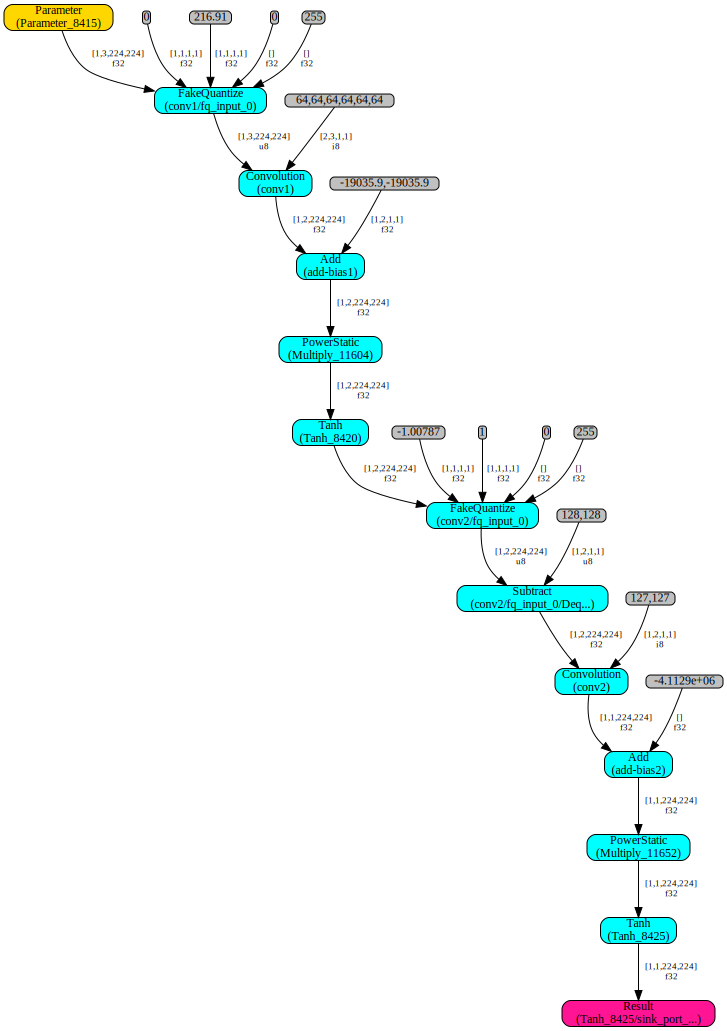

In [31]:
# now let's check LPT's result
visualize_model_before_opt(0)

We see some differences now:
 1. the dequantize operation `PowerStatic(Multiply_11604)` is inserted before `Tanh(Tanh_8420)`, because LPT cannot push it through a transcendental function, due to there is no easy way to recover $tanh(s(q-z))$ from $tanh(q)$.
 2. LPT is able to push the dequantize through `Add(add-bias1)`, since:
$$
\begin{align*}
add(dequant(q), b) &= add(s(q-z), b) \\
                   &= s(q-z) + b \\
                   &= s(q+b/s-z) \\
                   &= s(add(q,b/s)-z) \\
                   &= dequant(add(q, b/s))
\end{align*}
$$
 3. the `Subtract(conv2/fq_input_0/Deq...)` is added to substract zero-point from the output of second FakeQuantize node, 
    
    FakeQuantize with (levels,output_low,output_high)=(256,0,255) is essentially a `Quantization` to U8, and substract zero point from this quantization produces only scaled x.

```python
if x <= min(input_low, input_high):
    output = output_low
elif x > max(input_low, input_high):
    output = output_high
else:
    # input_low < x <= input_high
    output = round((x - input_low) / (input_high - input_low) * (levels-1)) / (levels-1) * (output_high - output_low) + output_low
           = round((x - input_low) / (input_high - input_low) * (256-1)) / (256-1) * (255 - 0) + 0
           = round((x - input_low) / (input_high - input_low) * 255)
           = round(x /((input_high - input_low)/255) + （-input_low*255/(input_high - input_low))
           = round(x / scale + zero_point)
```

Now we check what CPU plugin does with the model:

### FuseConvolutionAndZeroPoints
there is a big change in model topology between OPT_LINENUM 93-95, which is `FuseConvolutionAndZeroPoints()`, and this transform fuses the substract-

set_input_zero_points

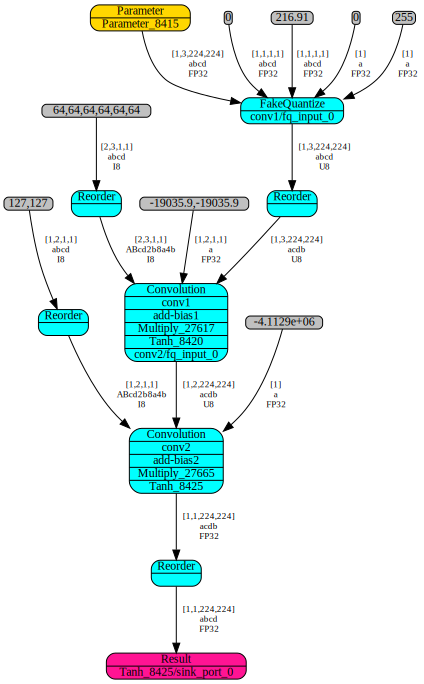

In [41]:
# now let's check final model, before(100) and after(110) FuseConvolutionAndSimpleOperation
visualize_model_before_opt()